In [2]:
import torch # used to create tensors to store all of the numerical values including the raw data and values for weights and biases
import torch.nn as nn # used to make weights and biases part of the neural network
import torch.nn.functional as F # gives us the activation functions 
from torch.optim import SGD # stochastic gradient descent to fit neural network to the data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# for each new neural network we create a new class
class BasicNN(nn.Module): 
    def __init__(self):
        super().__init__() #initialising the parent class
        #initialising weights and biases of the neural network
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False) # first weight 00 is initialised as 1.7 value and we wont be optimising it using gradient descent 
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad = False)

    def forward(self, input): # does a forward pass through the neural network to calclate and return the output value 
        # passing the input through the activation function in top layer
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        # transforming the output of the relu function in top layer
        scaled_top_relu_output = top_relu_output * self.w01

        # passing the input through the activation function in bottom layer
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        # transforming the output of the relu function in bottom layer
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [7]:
# we are using the examples of medicine does which do not work at low and high doses, but work at medium doses
input_doses = torch.linspace(start = 0, end = 1, steps = 11) # creating a tensor with a sequence of 11 values between and including 0 and 1
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [10]:
model = BasicNN()
output_values = model(input_doses)
output_values

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

<Axes: xlabel='None', ylabel='None'>

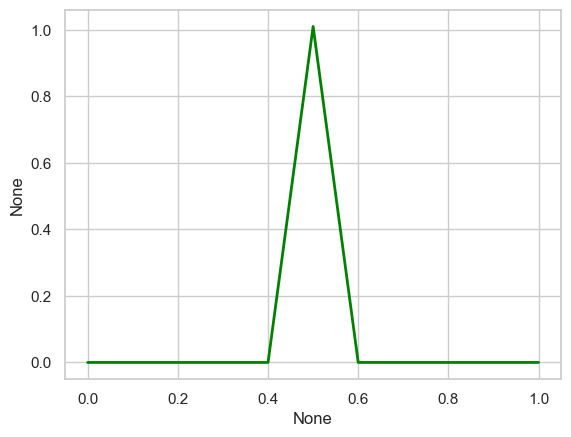

In [12]:
# plotting the predictions
sns.set(style = 'whitegrid')
sns.lineplot(x = input_doses, y = output_values, color = 'green', linewidth = 2)

In [13]:
# now we create another neural network where we dont not the value of the final_bias
# using pytorch to optimize the value of final_bias using backpropagation
# we randomly initialise final_bias to 0.0

In [ ]:
class BasicNN_train(nn.Module):
    def __init__(self):
        super()__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False) # first weight 00 is initialised as 1.7 value and we wont be optimising it using gradient descent 
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad = True)

    def forward(self, input): # does a forward pass through the neural network to calclate and return the output value 
        # passing the input through the activation function in top layer
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        # transforming the output of the relu function in top layer
        scaled_top_relu_output = top_relu_output * self.w01

        # passing the input through the activation function in bottom layer
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        # transforming the output of the relu function in bottom layer
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

